In [2]:
import numpy as np
import os

from nfvm.mesh.triangleMesh import TriangleMesh
from nfvm.field.volField import volScalarField
import nfvm.fvm as fvm
import nfvm.fvc as fvc

import matplotlib.pyplot as plt

# 复连通域算例

俄罗斯方块中的 **Z** 方块名字为 Cleveland， 这里基于其构建一个传热问题，左侧壁面310K，右侧壁面290K，其余边界为0梯度边界条件；并且上半部分和下半部分导热系数不同。

## 加载点和控制体

从 d:\salary\nFVM\examples\laplacian\../../resources/mesh/cylinder/cylinder.msh 加载网格...

重构网格拓扑关系 ...
重构网格拓扑关系 成功
初始化 TriangleMesh ...
初始化 TriangleMesh 成功


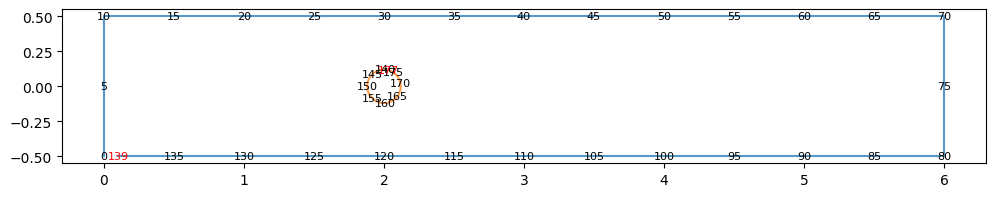

In [7]:
mshPath = os.path.join(os.getcwd(), '../../resources/mesh/cylinder/cylinder.msh')
mesh = TriangleMesh.fromMeshIO(mshPath)

mesh.boundary.resort([20, 165])
mesh.showBoundary(fontInterval=5, figsize=(12,2), fontsize=8, save=False)

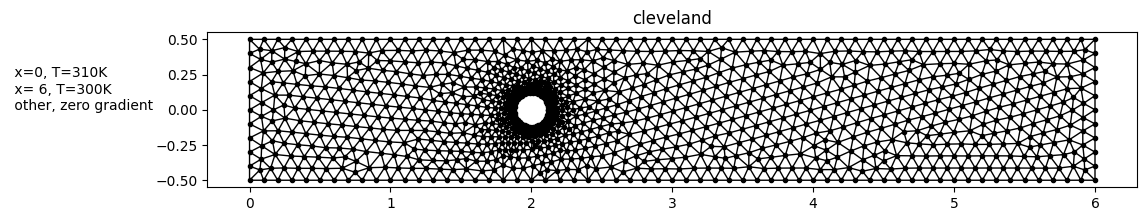

In [17]:
# 网格可视化

X = mesh.points[:,0]
Y = mesh.points[:,1]
triangles = mesh.cells 

fig, ax = plt.subplots(figsize=(12,3))
ax.set_aspect('equal')
tpc = ax.triplot(X, Y, triangles, 'ko-', markersize=3, lw=1.0)
ax.set_title('cleveland')

ax.text(-1.7, 0.0, " x=0, T=310K\n x= 6, T=300K\n other, zero gradient")

plt.show()

## 构造一个温度场

In [20]:
# 构造一个边界条
BN:int = mesh.boundary.size
k, b = np.ones(BN), np.zeros(BN)

# 0-10温度为310 
k[:10] = 0.0
b[0:10] = 310.0
# 70-80温度为300，
k[70:80] = 0.0
b[70:80] = 300.0
# 其余为绝热条件（0梯度条件），默认的 k=1.0, b=0.0就是0梯度

In [21]:
# 构造一个温度场并指定初始值

CN = mesh.cn
T = volScalarField("T", mesh, value=np.ones(CN)*300.0, boundary_dict={'k': k, 'b': b})

## 使用拉普拉斯算子构造稀疏矩阵

In [22]:
mat = fvm.Laplacian(T)

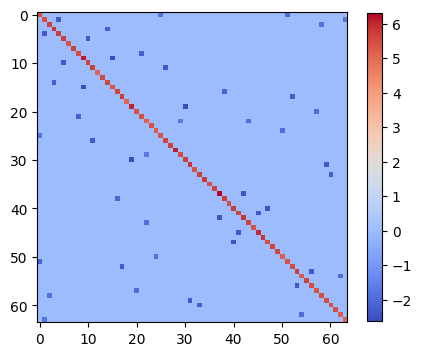

In [23]:
# 可视化稀疏矩阵
plt.figure(figsize=(5,5))

plt.imshow(mat.csr.todense()[:64,:64], cmap='coolwarm')
plt.colorbar(shrink=0.8)
# plt.savefig('sp-mat.png', dpi=150, bbox_inches='tight')
plt.show()

## 求解稀疏矩阵

使用`scipy.sparse.linalg`模块的`spsolve`函数求解稀疏矩阵。

In [24]:
# assignment 指定更新标量场T
_ = mat.solve(assignment=True)
# T.writeVTK()

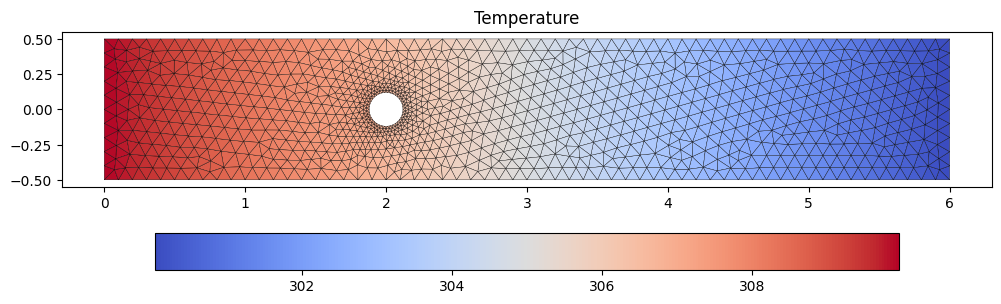

In [30]:
fig, ax = plt.subplots(figsize=(12,4))
ax.set_aspect('equal')
tpc = ax.tripcolor(X, Y, triangles, facecolors=T.value, cmap='coolwarm', edgecolors='k')
fig.colorbar(tpc, shrink=0.8, orientation='horizontal')
ax.set_title('Temperature')

plt.show()